# RGI01 outlines selection

In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import numpy as np
from utils import mkdir

## Read the file 

In [2]:
idir = '../l2_sel_reg_tars/'

reg = 1
odir = mkdir('../l3_rgi7a')
odir_tar = mkdir('../l3_rgi7a_tar')

rgi6_reg_file = '../l0_RGIv6/01_rgi60_Alaska.zip'

In [3]:
# Read L2 files
shp = gpd.read_file('tar://' + idir + f'RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

## Outline selection 

In [4]:
# List analysts
shp.analysts.unique()

array(['Beedle, Matthew', 'Manley, William', 'Herreid, Samuel',
       'Frey, Holger; Le Bris, Raymond; Paul, Frank', 'Rich, Justin',
       'Bolch, Tobias',
       'Beedle, Matthew; Berthier, Etienne; Bolch, Tobias; Burgess, Evan; Cogley, Graham; Forster, Richard; Giffen, Bruce A.; Hall, Dorothy K.; Kienholz, Christian; LeBris, Raymond; Manley, William',
       'Maraldo, Dean'], dtype=object)

For this region selecting glaciers can be done either by analyst or by "proc_desc":

In [5]:
sel_analysts = ('Beedle, Matthew; Berthier, Etienne; Bolch, Tobias; Burgess, Evan; Cogley, Graham; '
                'Forster, Richard; Giffen, Bruce A.; Hall, Dorothy K.; Kienholz, Christian; LeBris, Raymond; Manley, William')
len(shp.loc[shp.analysts == sel_analysts])

27106

In [6]:
sel_proc_desc = ('Semi-automated glacier classification.; From Randolph Glacier Inventory Version 5.0. Source file: 01_rgi50_Alaska.zip.  '
                 'See http://www.glims.org/RGI/.  GLIMS IDs were adjusted and metadata was added at NSIDC.')
len(shp.loc[shp.proc_desc == sel_proc_desc])

27106

In [7]:
rgi7 = shp.loc[shp.analysts == sel_analysts].copy()

## Consistency check with RGI6 

In [8]:
# Just to know the name of the file to open from zip
import zipfile
with zipfile.ZipFile(rgi6_reg_file, "r") as z:
    for f in z.filelist:
        print(f.filename)

01_rgi60_Alaska.dbf
01_rgi60_Alaska.prj
01_rgi60_Alaska.shp
01_rgi60_Alaska.shx
01_rgi60_Alaska_hypso.csv


In [9]:
rgi6 = gpd.read_file('zip://' + rgi6_reg_file + '/01_rgi60_Alaska.shp')

In [10]:
len(rgi7), len(rgi6)

(27106, 27108)

There are two missing glaciers! One has been wrongly attributed to Region 1 in the RGI6 (`RGI60-01.05285`), another we don't know yet.

In [11]:
rgi6 = rgi6.loc[rgi6.RGIId != 'RGI60-01.05285'].copy()

Test the areas:

In [12]:
rgi6['Area_us'] = rgi6.to_crs({'proj':'cea'}).area 
rgi7['area'] = rgi7.to_crs({'proj':'cea'}).area 

In [13]:
print('Area RGI7a (km2)', rgi7['area'].sum() * 1e-6)
print('Area RGI6 (km2)', rgi6['Area'].sum())
print('Area RGI6 computed by us (km2)', rgi6['Area_us'].sum() * 1e-6)
print('diff areas RGI6 - RGI7 computed by us (m2)', rgi6['Area_us'].sum() - rgi7['area'].sum())

Area RGI7a (km2) 86724.5510826829
Area RGI6 (km2) 86724.631
Area RGI6 computed by us (km2) 86724.5515302422
diff areas RGI6 - RGI7 computed by us (m2) 447.5592956542969


So, the difference is really small...

In [14]:
rgi6_sorted = rgi6.sort_values(by='Area_us')
rgi7_sorted = rgi7.sort_values(by='area')

In [15]:
rgi6_area = rgi6_sorted['Area_us'].values
rgi7_area = rgi7_sorted['area'].values

In [16]:
tdf = pd.DataFrame()
tdf['diff']= np.abs(rgi7_area - rgi6_area[:-1])
tdf['diff_shifted'] = np.abs(rgi7_area - rgi6_area[1:])

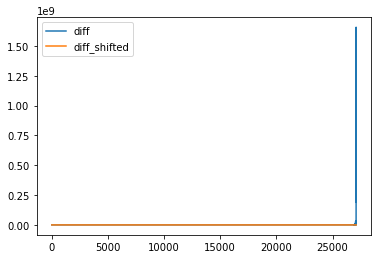

In [17]:
tdf.plot();

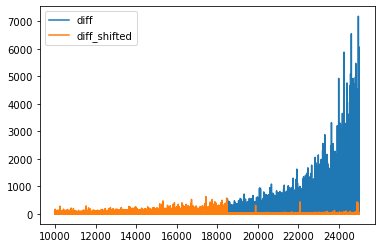

In [18]:
tdf[10000:25000].plot();

So there is a moment where the difference get consistently changed. Let's find this sweet spot:

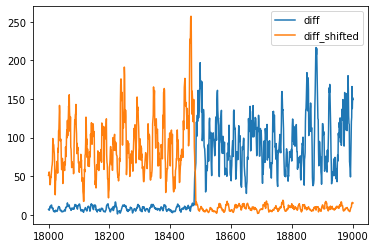

In [19]:
tdf.rolling(7).mean().loc[18000:19000].plot();

In [20]:
tdfr = tdf.rolling(7).mean().loc[18000:20000]

In [21]:
tdfr.loc[tdfr['diff_shifted'] < tdfr['diff']]

,diff,diff_shifted
18482,56.569328,56.112750
18483,62.888900,39.239642
18484,67.176456,12.494784
18485,103.613081,14.885734
18486,120.215048,16.162821
...,...,...
19996,148.449097,3.249797
19997,160.718212,3.322610
19998,223.886658,8.343046
19999,210.836979,9.704442


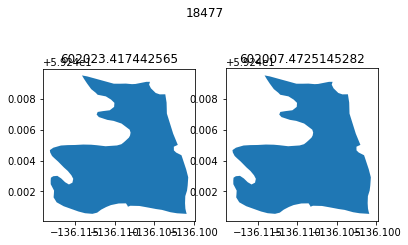

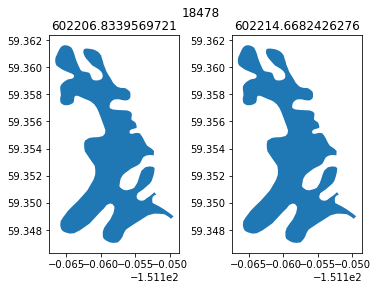

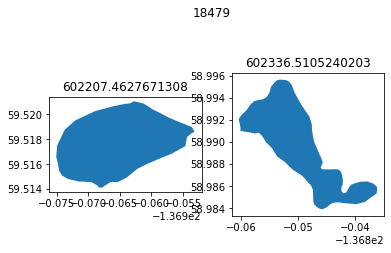

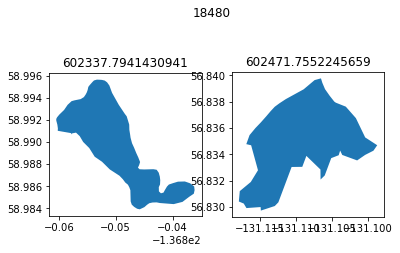

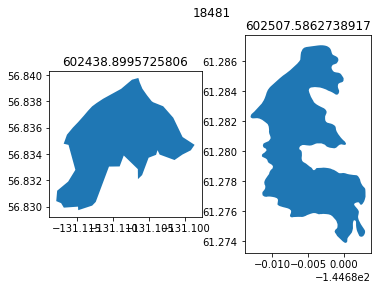

In [22]:
for i in range(18482-5, 18482+1):
    f, (ax1, ax2) = plt.subplots(1, 2);
    rgi6_sorted.iloc[[i]].plot(ax=ax1);
    ax1.set_title(rgi6_sorted.iloc[i]['Area_us']);
    rgi7_sorted.iloc[[i]].plot(ax=ax2);
    ax2.set_title(rgi7_sorted.iloc[i]['area']);
    plt.suptitle(i)
plt.close();

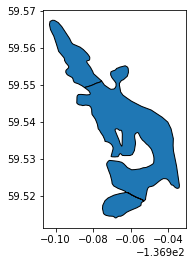

In [23]:
rgi7.loc[rgi7.anlys_id == 409341].plot(edgecolor='k');

In [24]:
rgi7.loc[rgi7.anlys_id == 409341]

,line_type,anlys_id,glac_id,anlys_time,area,db_area,width,length,primeclass,min_elev,...,chief_affl,loc_unc_x,loc_unc_y,glob_unc_x,glob_unc_y,submitters,analysts,CenLon,CenLat,geometry
35114,glac_bound,409341.0,G223040E59540N,2015-07-16T00:00:00,1.186391e+06,7.08127,0.0,0.0,0.0,1436.0,...,University of Colorado,50,50,80,80,"Cogley, Graham","Beedle, Matthew; Berthier, Etienne; Bolch, Tob...",-134.344814,58.6313,"POLYGON Z ((-136.97548 59.55107 0.00000, -136...."
35115,glac_bound,409341.0,G223040E59540N,2015-07-16T00:00:00,5.894882e+06,7.08127,0.0,0.0,0.0,1436.0,...,University of Colorado,50,50,80,80,"Cogley, Graham","Beedle, Matthew; Berthier, Etienne; Bolch, Tob...",-134.344814,58.6313,"POLYGON Z ((-136.95316 59.51861 0.00000, -136...."


We have found the problem! Reported here: https://github.com/GLIMS-RGI/glims_issue_tracker/issues/5

## Write out and tar 

In [25]:
dd = mkdir(f'{odir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{odir_tar}/RGI{reg:02d}.tar.gz', '-C', odir, f'RGI{reg:02d}']))

Writing...
Taring...
CompletedProcess(args=['tar', '-zcvf', '../l3_rgi7a_tar/RGI01.tar.gz', '-C', '../l3_rgi7a', 'RGI01'], returncode=0)
